In [1]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 94.4MB/s]


# **Step one: Receiving Dataset, Data Visualization and Preprocessing**

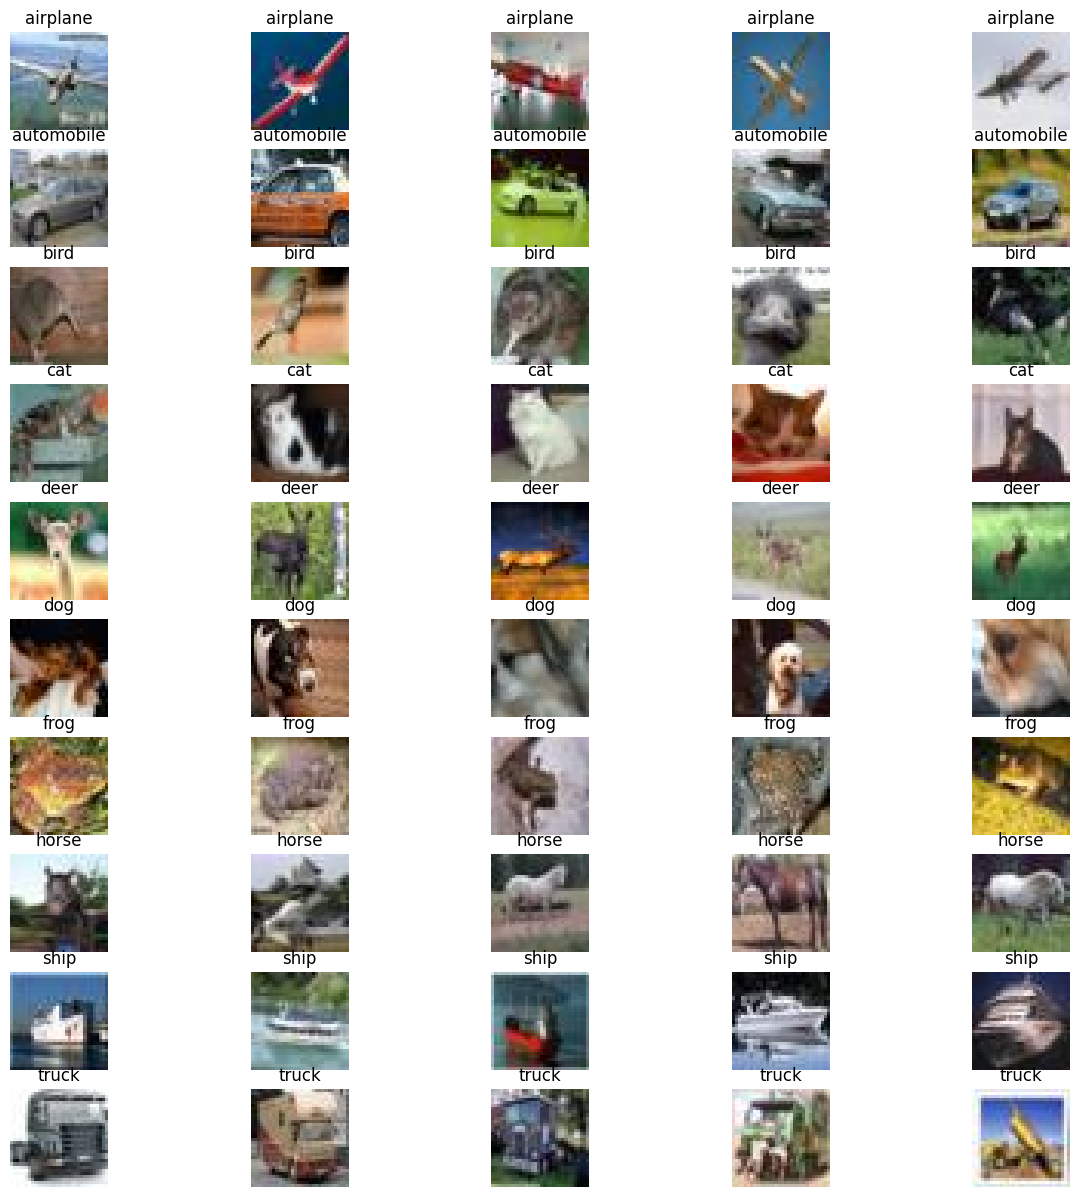

In [2]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

# Define the classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Function to load and visualize images
def visualize_samples(data_dir, num_samples=5):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 15))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
        for j in range(num_samples):
            img_path = image_paths[j]
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    plt.show()

# Visualize sample images from the training set
train_dir = 'CIFAR10/train'
visualize_samples(train_dir)


**1. Preprocessing**

In [4]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

# Function to read images and labels for a given class
def read_images_and_labels(data_dir, classes, num_samples_per_class):
    images = []
    labels = []
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
        image_paths = image_paths[:num_samples_per_class]  # Limit number of samples per class
        for img_path in image_paths:
            img = imread(img_path)
            img_resized = resize(img, (32, 32))  # Resize images to 32x32
            images.append(img_resized)
            label = np.zeros(len(classes))
            label[i] = 1  # One-hot encoding for the class
            labels.append(label)
    return np.array(images), np.array(labels)

# Define directories
train_dir = 'CIFAR10/train'
test_dir = 'CIFAR10/test'

# Define classes
classes = ['airplane', 'automobile', 'bird', 'cat']

# Number of samples per class
num_samples_per_class = 5000  # 5000 samples per class for training and testing

# Read training data
train_images, train_labels = read_images_and_labels(train_dir, classes, num_samples_per_class)

# Read test data
test_images, test_labels = read_images_and_labels(test_dir, classes, num_samples_per_class)

# Print shapes of the loaded data
print("Shape of training images:", train_images.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of test images:", test_images.shape)
print("Shape of test labels:", test_labels.shape)


Shape of training images: (20000, 32, 32, 3)
Shape of training labels: (20000, 4)
Shape of test images: (4000, 32, 32, 3)
Shape of test labels: (4000, 4)


**2. rgb2gray**

In [5]:
def rgb2gray(rgb):
    r, g, b = rgb[:, :, :, 0], rgb[:, :, :, 1], rgb[:, :, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

# Convert training and test images to grayscale
train_images_gray = rgb2gray(train_images)
test_images_gray = rgb2gray(test_images)

# Print shapes of the grayscale images
print("Shape of grayscale training images:", train_images_gray.shape)
print("Shape of grayscale test images:", test_images_gray.shape)


Shape of grayscale training images: (20000, 32, 32)
Shape of grayscale test images: (4000, 32, 32)


**3. Normalization**

In [6]:
# Normalize grayscale images
train_images_normalized = train_images_gray / 255.0
test_images_normalized = test_images_gray / 255.0

# Print shapes of the normalized images
print("Shape of normalized training images:", train_images_normalized.shape)
print("Shape of normalized test images:", test_images_normalized.shape)


Shape of normalized training images: (20000, 32, 32)
Shape of normalized test images: (4000, 32, 32)


**4. Flattern**

In [7]:
# Flatten the normalized images
train_images_flattened = train_images_normalized.reshape(train_images_normalized.shape[0], -1)
test_images_flattened = test_images_normalized.reshape(test_images_normalized.shape[0], -1)

# Print shapes of the flattened images
print("Shape of flattened training images:", train_images_flattened.shape)
print("Shape of flattened test images:", test_images_flattened.shape)


Shape of flattened training images: (20000, 1024)
Shape of flattened test images: (4000, 1024)


**5. Shuffle**

In [8]:
def shuffle_data(images, labels):
    assert len(images) == len(labels), "Number of images and labels must be equal"
    permutation = np.random.permutation(len(images))
    shuffled_images = images[permutation]
    shuffled_labels = labels[permutation]
    return shuffled_images, shuffled_labels

# Shuffle the training data
train_images_shuffled, train_labels_shuffled = shuffle_data(train_images_flattened, train_labels)

# Shuffle the test data (not necessary before training, but for consistency)
test_images_shuffled, test_labels_shuffled = shuffle_data(test_images_flattened, test_labels)

# Print shapes of the shuffled data
print("Shape of shuffled training images:", train_images_shuffled.shape)
print("Shape of shuffled training labels:", train_labels_shuffled.shape)
print("Shape of shuffled test images:", test_images_shuffled.shape)
print("Shape of shuffled test labels:", test_labels_shuffled.shape)


Shape of shuffled training images: (20000, 1024)
Shape of shuffled training labels: (20000, 4)
Shape of shuffled test images: (4000, 1024)
Shape of shuffled test labels: (4000, 4)


# **Step 2: Calculating The Output (Feedforward)**

In [13]:
import numpy as np

# Select 200 random data points from the training set
selected_indices = np.random.choice(train_images_shuffled.shape[0], 200, replace=False)
selected_images = train_images_shuffled[selected_indices]
selected_labels = train_labels_shuffled[selected_indices]

# Define the sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Initialize weights and biases
np.random.seed(42)  # For reproducibility
num_input_neurons = selected_images.shape[1]
num_output_neurons = selected_labels.shape[1]
hidden_layer_size = 128  # Example hidden layer size
weights_hidden = np.random.randn(num_input_neurons, hidden_layer_size)
biases_hidden = np.zeros(hidden_layer_size)
weights_output = np.random.randn(hidden_layer_size, num_output_neurons)
biases_output = np.zeros(num_output_neurons)

# Feedforward calculation
hidden_output = sigmoid(np.dot(selected_images, weights_hidden) + biases_hidden)
output = sigmoid(np.dot(hidden_output, weights_output) + biases_output)

# Determine predicted labels
predicted_labels = np.argmax(output, axis=1)
true_labels = np.argmax(selected_labels, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_labels == true_labels)
print("Accuracy of the model:", accuracy)


Accuracy of the model: 0.205


# **Step 3: Implementation of Backpropagation**

Epoch 1, Average Cost: 0.19917714689163332
Epoch 2, Average Cost: 0.1944761948106192
Epoch 3, Average Cost: 0.19153079848712035
Epoch 4, Average Cost: 0.18942844765610564
Epoch 5, Average Cost: 0.1876413813625674
Epoch 6, Average Cost: 0.18601741027076835
Epoch 7, Average Cost: 0.18456864115115618
Epoch 8, Average Cost: 0.18382979094083216
Epoch 9, Average Cost: 0.1826381126531636
Epoch 10, Average Cost: 0.1820688458038623


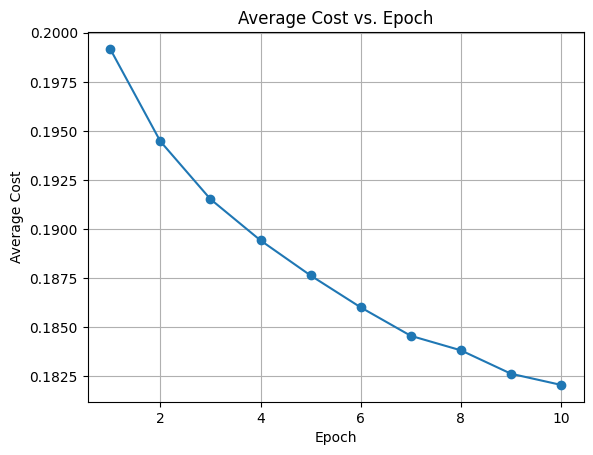

Execution Time: 39.04673957824707
Accuracy of the model: 0.2855


In [15]:
import time
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.3
number_of_epochs = 10
batch_size = 16

# Initialize weights and biases
np.random.seed(42)  # For reproducibility
weights_hidden = np.random.randn(num_input_neurons, hidden_layer_size)
biases_hidden = np.zeros(hidden_layer_size)
weights_output = np.random.randn(hidden_layer_size, num_output_neurons)
biases_output = np.zeros(num_output_neurons)

# Define the sigmoid derivative function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Training loop
start_time = time.time()
avg_cost_per_epoch = []
for epoch in range(number_of_epochs):
    # Shuffle the training set
    train_images_shuffled, train_labels_shuffled = shuffle_data(train_images_flattened, train_labels)

    # Initialize variables for average cost calculation
    total_cost = 0
    num_batches = 0

    # Iterate through batches
    for batch_start in range(0, len(train_images_shuffled), batch_size):
        batch_end = batch_start + batch_size
        batch_images = train_images_shuffled[batch_start:batch_end]
        batch_labels = train_labels_shuffled[batch_start:batch_end]

        # Forward pass
        hidden_output = sigmoid(np.dot(batch_images, weights_hidden) + biases_hidden)
        output = sigmoid(np.dot(hidden_output, weights_output) + biases_output)

        # Backward pass (compute gradients)
        d_output = 2 * (output - batch_labels) * sigmoid_derivative(output)
        d_weights_output = np.dot(hidden_output.T, d_output)
        d_biases_output = np.sum(d_output, axis=0)
        d_hidden = np.dot(d_output, weights_output.T) * sigmoid_derivative(hidden_output)
        d_weights_hidden = np.dot(batch_images.T, d_hidden)
        d_biases_hidden = np.sum(d_hidden, axis=0)

        # Update weights and biases
        weights_output -= learning_rate * (d_weights_output / batch_size)
        biases_output -= learning_rate * (d_biases_output / batch_size)
        weights_hidden -= learning_rate * (d_weights_hidden / batch_size)
        biases_hidden -= learning_rate * (d_biases_hidden / batch_size)

        # Calculate cost and accumulate for average cost calculation
        batch_cost = np.mean((output - batch_labels) ** 2)
        total_cost += batch_cost
        num_batches += 1

    # Calculate average cost for the epoch
    avg_cost = total_cost / num_batches
    avg_cost_per_epoch.append(avg_cost)
    print(f"Epoch {epoch + 1}, Average Cost: {avg_cost}")

# Plot average cost over epochs
plt.plot(range(1, number_of_epochs + 1), avg_cost_per_epoch, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Epoch')
plt.grid(True)
plt.show()

# Calculate execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time)

# Calculate accuracy
hidden_output = sigmoid(np.dot(test_images_flattened, weights_hidden) + biases_hidden)
output = sigmoid(np.dot(hidden_output, weights_output) + biases_output)
predicted_labels = np.argmax(output, axis=1)
true_labels = np.argmax(test_labels, axis=1)
accuracy = np.mean(predicted_labels == true_labels)
print("Accuracy of the model:", accuracy)


# **Step 4: Vectorization**

Run 1, Epoch 1, Average Cost: 0.19917714689163332
Run 1, Epoch 2, Average Cost: 0.1944761948106192
Run 1, Epoch 3, Average Cost: 0.19153079848712035
Run 1, Epoch 4, Average Cost: 0.18942844765610564
Run 1, Epoch 5, Average Cost: 0.1876413813625674
Run 1, Epoch 6, Average Cost: 0.18601741027076835
Run 1, Epoch 7, Average Cost: 0.18456864115115618
Run 1, Epoch 8, Average Cost: 0.18382979094083216
Run 1, Epoch 9, Average Cost: 0.1826381126531636
Run 1, Epoch 10, Average Cost: 0.1820688458038623
Run 1, Epoch 11, Average Cost: 0.18156667390353998
Run 1, Epoch 12, Average Cost: 0.18062491466984126
Run 1, Epoch 13, Average Cost: 0.1805740332821119
Run 1, Epoch 14, Average Cost: 0.1797995649308447
Run 1, Epoch 15, Average Cost: 0.17944231104747702
Run 1, Epoch 16, Average Cost: 0.17931580738001596
Run 1, Epoch 17, Average Cost: 0.1786477338065213
Run 1, Epoch 18, Average Cost: 0.17832867560242122
Run 1, Epoch 19, Average Cost: 0.17807175627024754
Run 1, Epoch 20, Average Cost: 0.17761905938759

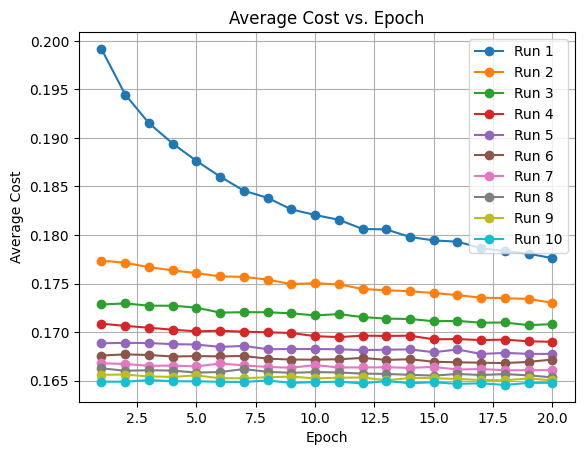

Average Accuracy of the model: 0.442325
Average Execution Time: 48.966098523139955


In [16]:
import time
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.3
number_of_epochs = 20
batch_size = 16
num_runs = 10

# Initialize weights and biases
np.random.seed(42)  # For reproducibility
weights_hidden = np.random.randn(num_input_neurons, hidden_layer_size)
biases_hidden = np.zeros(hidden_layer_size)
weights_output = np.random.randn(hidden_layer_size, num_output_neurons)
biases_output = np.zeros(num_output_neurons)

# Define the sigmoid derivative function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Training loop
avg_accuracy = 0
avg_execution_time = 0
avg_cost_palette = np.zeros(number_of_epochs)

for run in range(num_runs):
    start_time = time.time()
    avg_cost_per_epoch = []
    for epoch in range(number_of_epochs):
        # Shuffle the training set
        train_images_shuffled, train_labels_shuffled = shuffle_data(train_images_flattened, train_labels)

        # Initialize variables for average cost calculation
        total_cost = 0
        num_batches = 0

        # Iterate through batches
        for batch_start in range(0, len(train_images_shuffled), batch_size):
            batch_end = batch_start + batch_size
            batch_images = train_images_shuffled[batch_start:batch_end]
            batch_labels = train_labels_shuffled[batch_start:batch_end]

            # Forward pass
            hidden_output = sigmoid(np.dot(batch_images, weights_hidden) + biases_hidden)
            output = sigmoid(np.dot(hidden_output, weights_output) + biases_output)

            # Backward pass (compute gradients)
            d_output = 2 * (output - batch_labels) * sigmoid_derivative(output)
            d_weights_output = np.dot(hidden_output.T, d_output)
            d_biases_output = np.sum(d_output, axis=0)
            d_hidden = np.dot(d_output, weights_output.T) * sigmoid_derivative(hidden_output)
            d_weights_hidden = np.dot(batch_images.T, d_hidden)
            d_biases_hidden = np.sum(d_hidden, axis=0)

            # Update weights and biases
            weights_output -= learning_rate * (d_weights_output / batch_size)
            biases_output -= learning_rate * (d_biases_output / batch_size)
            weights_hidden -= learning_rate * (d_weights_hidden / batch_size)
            biases_hidden -= learning_rate * (d_biases_hidden / batch_size)

            # Calculate cost and accumulate for average cost calculation
            batch_cost = np.mean((output - batch_labels) ** 2)
            total_cost += batch_cost
            num_batches += 1

        # Calculate average cost for the epoch
        avg_cost = total_cost / num_batches
        avg_cost_per_epoch.append(avg_cost)
        print(f"Run {run + 1}, Epoch {epoch + 1}, Average Cost: {avg_cost}")

    # Plot average cost over epochs
    plt.plot(range(1, number_of_epochs + 1), avg_cost_per_epoch, marker='o', label=f"Run {run + 1}")
    plt.xlabel('Epoch')
    plt.ylabel('Average Cost')
    plt.title('Average Cost vs. Epoch')
    plt.grid(True)
    plt.legend()

    # Calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print("Run", run + 1, "Execution Time:", execution_time)
    avg_execution_time += execution_time

    # Calculate accuracy
    hidden_output = sigmoid(np.dot(test_images_flattened, weights_hidden) + biases_hidden)
    output = sigmoid(np.dot(hidden_output, weights_output) + biases_output)
    predicted_labels = np.argmax(output, axis=1)
    true_labels = np.argmax(test_labels, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    avg_accuracy += accuracy
    print("Run", run + 1, "Accuracy of the model:", accuracy)

    # Add cost palette of current run to the average cost palette
    avg_cost_palette += np.array(avg_cost_per_epoch)

# Calculate average accuracy, execution time, and cost palette
avg_accuracy /= num_runs
avg_execution_time /= num_runs
avg_cost_palette /= num_runs

# Show the plot
plt.show()

# Print average results
print("Average Accuracy of the model:", avg_accuracy)
print("Average Execution Time:", avg_execution_time)


# **Step 5: Testing the Model**

Run 1, Epoch 1, Average Cost: 0.19917714689163332
Run 1, Epoch 2, Average Cost: 0.1944761948106192
Run 1, Epoch 3, Average Cost: 0.19153079848712035
Run 1, Epoch 4, Average Cost: 0.18942844765610564
Run 1, Epoch 5, Average Cost: 0.1876413813625674
Run 1, Epoch 6, Average Cost: 0.18601741027076835
Run 1, Epoch 7, Average Cost: 0.18456864115115618
Run 1, Epoch 8, Average Cost: 0.18382979094083216
Run 1, Epoch 9, Average Cost: 0.1826381126531636
Run 1, Epoch 10, Average Cost: 0.1820688458038623
Run 1, Epoch 11, Average Cost: 0.18156667390353998
Run 1, Epoch 12, Average Cost: 0.18062491466984126
Run 1, Epoch 13, Average Cost: 0.1805740332821119
Run 1, Epoch 14, Average Cost: 0.1797995649308447
Run 1, Epoch 15, Average Cost: 0.17944231104747702
Run 1, Epoch 16, Average Cost: 0.17931580738001596
Run 1, Epoch 17, Average Cost: 0.1786477338065213
Run 1, Epoch 18, Average Cost: 0.17832867560242122
Run 1, Epoch 19, Average Cost: 0.17807175627024754
Run 1, Epoch 20, Average Cost: 0.17761905938759

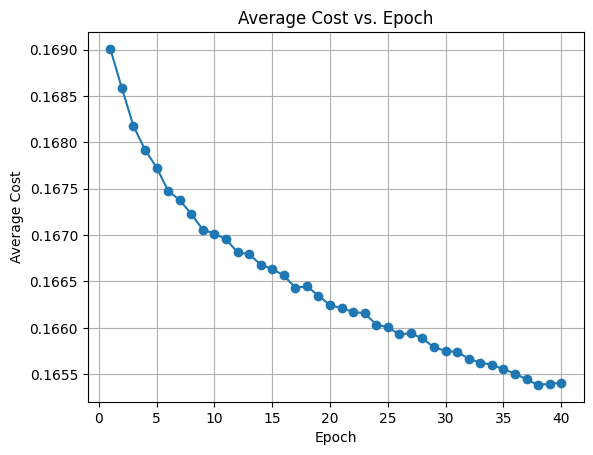

In [17]:
import time
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.3
number_of_epochs = 40
batch_size = 16
num_runs = 10

# Initialize weights and biases
np.random.seed(42)  # For reproducibility
weights_hidden = np.random.randn(num_input_neurons, hidden_layer_size)
biases_hidden = np.zeros(hidden_layer_size)
weights_output = np.random.randn(hidden_layer_size, num_output_neurons)
biases_output = np.zeros(num_output_neurons)

# Define the sigmoid derivative function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Training loop
avg_accuracy_train = 0
avg_accuracy_test = 0
avg_execution_time = 0
avg_cost_palette = np.zeros(number_of_epochs)

for run in range(num_runs):
    start_time = time.time()
    avg_cost_per_epoch = []
    for epoch in range(number_of_epochs):
        # Shuffle the training set
        train_images_shuffled, train_labels_shuffled = shuffle_data(train_images_flattened, train_labels)

        # Initialize variables for average cost calculation
        total_cost = 0
        num_batches = 0

        # Iterate through batches
        for batch_start in range(0, len(train_images_shuffled), batch_size):
            batch_end = batch_start + batch_size
            batch_images = train_images_shuffled[batch_start:batch_end]
            batch_labels = train_labels_shuffled[batch_start:batch_end]

            # Forward pass
            hidden_output = sigmoid(np.dot(batch_images, weights_hidden) + biases_hidden)
            output = sigmoid(np.dot(hidden_output, weights_output) + biases_output)

            # Backward pass (compute gradients)
            d_output = 2 * (output - batch_labels) * sigmoid_derivative(output)
            d_weights_output = np.dot(hidden_output.T, d_output)
            d_biases_output = np.sum(d_output, axis=0)
            d_hidden = np.dot(d_output, weights_output.T) * sigmoid_derivative(hidden_output)
            d_weights_hidden = np.dot(batch_images.T, d_hidden)
            d_biases_hidden = np.sum(d_hidden, axis=0)

            # Update weights and biases
            weights_output -= learning_rate * (d_weights_output / batch_size)
            biases_output -= learning_rate * (d_biases_output / batch_size)
            weights_hidden -= learning_rate * (d_weights_hidden / batch_size)
            biases_hidden -= learning_rate * (d_biases_hidden / batch_size)

            # Calculate cost and accumulate for average cost calculation
            batch_cost = np.mean((output - batch_labels) ** 2)
            total_cost += batch_cost
            num_batches += 1

        # Calculate average cost for the epoch
        avg_cost = total_cost / num_batches
        avg_cost_per_epoch.append(avg_cost)
        print(f"Run {run + 1}, Epoch {epoch + 1}, Average Cost: {avg_cost}")

    # Calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print("Run", run + 1, "Execution Time:", execution_time)
    avg_execution_time += execution_time

    # Calculate accuracy for train set
    hidden_output_train = sigmoid(np.dot(train_images_flattened, weights_hidden) + biases_hidden)
    output_train = sigmoid(np.dot(hidden_output_train, weights_output) + biases_output)
    predicted_labels_train = np.argmax(output_train, axis=1)
    true_labels_train = np.argmax(train_labels, axis=1)
    accuracy_train = np.mean(predicted_labels_train == true_labels_train)
    avg_accuracy_train += accuracy_train
    print("Run", run + 1, "Accuracy of the model (train):", accuracy_train)

    # Calculate accuracy for test set
    hidden_output_test = sigmoid(np.dot(test_images_flattened, weights_hidden) + biases_hidden)
    output_test = sigmoid(np.dot(hidden_output_test, weights_output) + biases_output)
    predicted_labels_test = np.argmax(output_test, axis=1)
    true_labels_test = np.argmax(test_labels, axis=1)
    accuracy_test = np.mean(predicted_labels_test == true_labels_test)
    avg_accuracy_test += accuracy_test
    print("Run", run + 1, "Accuracy of the model (test):", accuracy_test)

    # Add cost palette of current run to the average cost palette
    avg_cost_palette += np.array(avg_cost_per_epoch)

# Calculate average accuracy, execution time, and cost palette
avg_accuracy_train /= num_runs
avg_accuracy_test /= num_runs
avg_execution_time /= num_runs
avg_cost_palette /= num_runs

# Print average results
print("Average Accuracy of the model (train):", avg_accuracy_train)
print("Average Accuracy of the model (test):", avg_accuracy_test)
print("Average Execution Time:", avg_execution_time)

# Plot average cost over epochs
plt.plot(range(1, number_of_epochs + 1), avg_cost_palette, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Epoch')
plt.grid(True)
plt.show()
